# Building Frederike's third force field

In [1]:
import matplotlib.pyplot as plt
import ase.io as io
from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=False

In [2]:
import os
print(os.getcwd())

C:\Users\Fremo211\Documents\repos\Tantalizing\fourth_run


### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [16]:
import os

# Remove if it already exists
def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass
rm("data_list.txt")

f = open("data_list.txt", "w")
outcar_names = os.listdir("OUTCARS/")
for name in outcar_names:
    print(name)
    f.write(name + "\n")
f.close()

1.OUTCAR
10.OUTCAR
100.OUTCAR
101.OUTCAR
102.OUTCAR
103.OUTCAR
104.OUTCAR
105.OUTCAR
106.OUTCAR
107.OUTCAR
108.OUTCAR
109.OUTCAR
11.OUTCAR
110.OUTCAR
111.OUTCAR
112.OUTCAR
113.OUTCAR
114.OUTCAR
115.OUTCAR
116.OUTCAR
117.OUTCAR
118.OUTCAR
119.OUTCAR
12.OUTCAR
120.OUTCAR
121.OUTCAR
122.OUTCAR
123.OUTCAR
124.OUTCAR
125.OUTCAR
126.OUTCAR
127.OUTCAR
128.OUTCAR
129.OUTCAR
13.OUTCAR
130.OUTCAR
131.OUTCAR
132.OUTCAR
133.OUTCAR
134.OUTCAR
135.OUTCAR
136.OUTCAR
137.OUTCAR
138.OUTCAR
139.OUTCAR
14.OUTCAR
140.OUTCAR
141.OUTCAR
142.OUTCAR
143.OUTCAR
144.OUTCAR
145.OUTCAR
146.OUTCAR
147.OUTCAR
148.OUTCAR
149.OUTCAR
15.OUTCAR
150.OUTCAR
151.OUTCAR
152.OUTCAR
153.OUTCAR
154.OUTCAR
155.OUTCAR
156.OUTCAR
157.OUTCAR
158.OUTCAR
159.OUTCAR
16.OUTCAR
160.OUTCAR
161.OUTCAR
162.OUTCAR
163.OUTCAR
164.OUTCAR
165.OUTCAR
166.OUTCAR
167.OUTCAR
168.OUTCAR
169.OUTCAR
17.OUTCAR
170.OUTCAR
171.OUTCAR
172.OUTCAR
173.OUTCAR
174.OUTCAR
175.OUTCAR
176.OUTCAR
177.OUTCAR
178.OUTCAR
179.OUTCAR
18.OUTCAR
180.OUTCAR
181.OUTCAR

In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="DFT.db",file_list="data_list.txt",overwrite=True, greedy=False)

    Building data-bases: 100%|██████████████████████████████████████████| 227/227 [00:10<00:00, 21.04it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [4]:
!ase db DFT.db

id|age|formula    |calculator|  energy|natoms| fmax|pbc| volume|charge|    mass| smax|magmom
 1|12s|Li5Ni12O24 |vasp      |-254.635|    41|0.020|TTT|384.052| 0.000|1122.997|0.001| 5.000
 2|12s|LiNi16O32  |vasp      |-309.442|    49|0.017|TTT|487.974| 0.000|1458.002|0.000| 0.999
 3|12s|LiNi12O24  |vasp      |-233.370|    37|0.019|TTT|367.828| 0.000|1095.237|0.000| 1.000
 4|11s|Li2Ni16O32 |vasp      |-314.617|    50|0.015|TTT|492.245| 0.000|1464.942|0.000|-2.000
 5|11s|Li3Ni16O32 |vasp      |-320.271|    51|0.015|TTT|496.022| 0.000|1471.882|0.000| 0.962
 6|11s|Li5Ni16O32 |vasp      |-330.792|    53|0.018|TTT|504.463| 0.000|1485.762|0.000| 5.001
 7|11s|Li4Ni12O24 |vasp      |-249.265|    40|0.016|TTT|381.190| 0.000|1116.057|0.001| 4.000
 8|11s|Li6Ni16O32 |vasp      |-336.057|    54|0.019|TTT|508.163| 0.000|1492.702|0.000| 6.002
 9|11s|Li4Ni12O24 |vasp      |-249.461|    40|0.013|TTT|381.125| 0.000|1116.057|0.000| 4.000
10|11s|Li13Ni27O54|vasp      |-574.107|    94|0.018|TTT|868.408| 0.000

In [5]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=Fit_on_forces)

    Fetching data: 100%|████████████████████████████████████████████████| 227/227 [00:06<00:00, 33.86it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [6]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 1.0,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [7]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: Li-Li
    Adding pair: Li-Ni
    Adding pair: Li-O
    Adding pair: Ni-Ni
    Adding pair: Ni-O
    Adding pair: O-O
    Applying monotonic constraints for pair:  Li-Li
    Applying monotonic constraints for pair:  Li-Ni
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Ni-Ni; number of intervals reduced from 5 to 4. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O


    Finding optimum switch: 100%|███████████████████████████████████| 21600/21600 [03:55<00:00, 91.56it/s]
C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ccs_fit\fitting\spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


    The best switch is (3, 4, 0, 3, 0, 5) with rmse: 0.27367681670174404, corresponding to distances of [5.16 6.17 1.38 5.1  1.19 6.72] Å for element pairs ['Li-Li', 'Li-Ni', 'Li-O', 'Ni-Ni', 'Ni-O', 'O-O'].


In [14]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.16,
                        "range_width": 0.5
                },
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "rep",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 6.17,
                        "range_width": 1
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.38,
                        "range_width": 1
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.1,
                        "range_width": 1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.19,
                        "range_width": 1
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "rep",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 6.72,
                        "range_width": 0.5
                },
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [15]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonic constraints for pair:  Li-Li
    Applying monotonic constraints for pair:  Li-Ni
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Li-Li; number of intervals reduced from 169 to 139. 
    Merging intervals for pair Li-Ni; number of intervals reduced from 168 to 124. 
    Merging intervals for pair Li-O; number of intervals reduced from 208 to 175. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 172 to 104. 
    Merging intervals for pair Ni-O; number of intervals reduced from 218 to 168. 
    Merging intervals for pair O-O; number of intervals reduced from 191 to 190. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range 

    Finding optimum switch: 100%|█████████████████████████████████████| 1250/1250 [13:11<00:00,  1.58it/s]


    The best switch is (137, 124, 0, 101, 0, 190) with rmse: 0.1712045560141435, corresponding to distances of [5.39 5.14 1.87 4.61 1.68 6.01] Å for element pairs ['Li-Li', 'Li-Ni', 'Li-O', 'Ni-Ni', 'Ni-O', 'O-O'].


C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\ccs_fit\fitting\spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


In [22]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.25,
                        "range_width": 1,
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.25,
                        "range_width": 1
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [23]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonic constraints for pair:  Li-Li
    Applying monotonic constraints for pair:  Li-Ni
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Li-Li; number of intervals reduced from 69 to 58. 
    Merging intervals for pair Li-Ni; number of intervals reduced from 69 to 54. 
    Merging intervals for pair Li-O; number of intervals reduced from 208 to 175. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 70 to 46. 
    Merging intervals for pair Ni-O; number of intervals reduced from 218 to 168. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Li-O; 37 possible switch indices in range of 1.87-3.23

    Finding optimum switch: 100%|███████████████████████████████████████| 851/851 [03:12<00:00,  4.43it/s]


    The best switch is (58, 54, 22, 46, 4, 78) with rmse: 0.12126829758844643, corresponding to distances of [5.54 5.35 2.31 4.87 1.76 6.09] Å for element pairs ['Li-Li', 'Li-Ni', 'Li-O', 'Ni-Ni', 'Ni-O', 'O-O'].


### 2nd iteration of fitting

In [ ]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_center": 4.34,
                        "range_width": 0.5
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_center": 4.82,
                        "range_width": 0.5
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.56,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.78,
                        "range_width": 0.5
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.1,
                        "range_width": 0.5
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.02,
                        "range_width": 0.5
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [ ]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

In [ ]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.07,
                        "range_width": 0.5
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.39,
                        "range_width": 0.5
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.64,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.57,
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.35,
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.82,
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [ ]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

In [ ]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.07,
                        "range_width": 0.1
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.39,
                        "range_width": 0.1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.84,
                        "range_width": 0.2
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [5.57],
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [4.35],
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [4.82],
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [ ]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [25]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT.db")

100%|███████████████████████████████████████████████████████████████████| 227/227 [00:24<00:00,  9.34it/s]


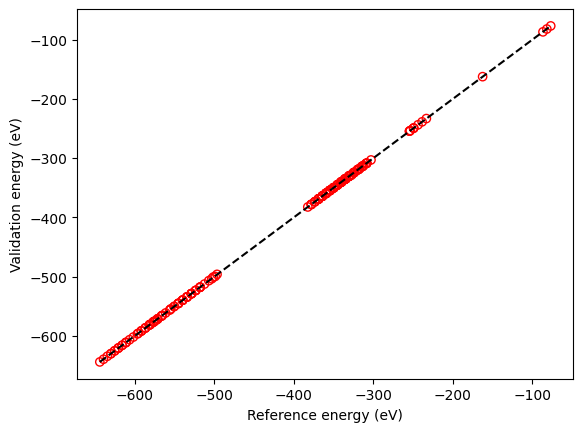

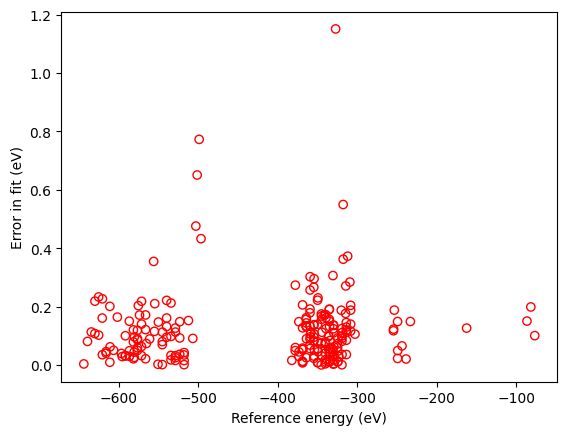

In [18]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Cleaning up

In [ ]:
# import glob

# def rm(file):
#     try:
#         os.remove(file)
#     except OSError:
#         pass


# list=glob.glob("CALCULATED_DATA/*")
# for file in list:
#     rm(file)
# list=glob.glob("CCS_*")
# for file in list:
#     rm(file)
# list=glob.glob("UNC_*")
# for file in list:
#     rm(file)
# rm("structures.json")
# rm("file_list")
# rm("LJ.db")

### Convex hull

In [3]:
struct_no_Li = io.read('DFT.db@149')
struct_full_Li = io.read('DFT.db@108')

nrg_0 = struct_no_Li.get_potential_energy()
nrg_1 = struct_full_Li.get_potential_energy()

print(struct_no_Li.get_chemical_formula())
print(struct_full_Li.get_chemical_formula())

Ni27O54
Li27Ni27O54


16 1.0 -382.50416114
17 0.0 -303.01470999
108 1.0 -644.16504923
149 0.0 -507.0774033
203 0.0 -503.24380737
205 0.0 -499.04874637
206 0.0 -496.7166306
207 0.0 -501.56477909
209 0.0 -76.89609961


Text(0, 0.5, 'Energy')

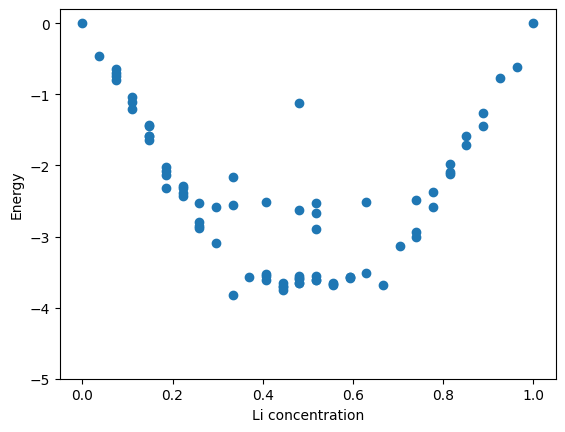

In [7]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db
import matplotlib.pyplot as plt

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
CCS_nrgs = []

i = 0

struct_no_Li_CCS = struct_no_Li.copy()
struct_full_Li_CCS = struct_full_Li.copy()

struct_no_Li_CCS.calc = CCS_calc
struct_full_Li_CCS.calc = CCS_calc

ECCS_no_Li = struct_no_Li_CCS.get_potential_energy()
ECCS_full_Li = struct_full_Li_CCS.get_potential_energy()

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(structure.get_magnetic_moments())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy()
    if x==0 or x==1:
        print(i,x,EDFT)
    structure.calc = CCS_calc
    ECCS = structure.get_potential_energy() - (ECCS_no_Li) - (ECCS_full_Li-ECCS_no_Li)/27*nr_Li
    xs.append(x)
    CCS_nrgs.append(ECCS)
    i += 1

plt.ylim(-5, 0.2)
plt.scatter(xs, CCS_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

Text(0, 0.5, 'Energy')

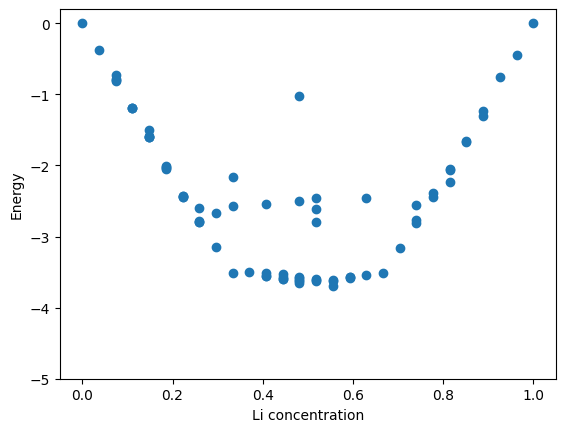

In [5]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
DFT_nrgs = []

i = 0

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(i)
    # print(dir(structure))
    # print(structure.get_magnetic_moment())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy() - (nrg_0) - (nrg_1-nrg_0)/27*nr_Li
    xs.append(x)
    DFT_nrgs.append(EDFT)
    i += 1

plt.ylim(-5, 0.2)
plt.scatter(xs, DFT_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

In [ ]:
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from ase import io

struct = io.read('DFT.db@10')

struct = struct * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)

# struct.rattle(0.05)
struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.001)

      Step     Time          Energy         fmax
BFGS:    0 09:07:02    -2035.327914        6.6521
BFGS:    1 09:08:29    -1848.456850       95.2570
BFGS:    2 09:09:48     -764.033950     1518.0008
BFGS:    3 09:11:22    -1984.993509        7.4949
BFGS:    4 09:42:31    -3038.678211      527.1191
BFGS:    5 09:44:15    54856.021648    11129.7155
BFGS:    6 09:45:52   180137.771575    17257.8070
BFGS:    7 09:49:26   457350.492968    73840.4234
BFGS:    8 09:51:40   822006.186279   185972.6443
BFGS:    9 09:53:24  1273424.146304   472014.8248
BFGS:   10 09:55:23  1711826.719386   254468.6061
BFGS:   11 09:57:05  2190820.104122   164169.2330
BFGS:   12 09:58:29  2257402.370419   221935.2118
BFGS:   13 09:59:50  2319596.990871   249589.4383
BFGS:   14 10:01:09  2258697.160032   256838.0538
BFGS:   15 10:02:22  2303475.371210   317553.2712
BFGS:   16 10:03:33  2501381.732463   485856.2926
BFGS:   17 10:04:44  2831052.608731   304335.3068
BFGS:   18 10:05:54  3100399.123831   305547.6799
B

In [ ]:
!ase gui opt.traj

In [25]:
# Read geometry optimized structure and run NVE Molecular dynamics 
import numpy as np
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet

dt = 0.5 * units.fs
steps = int(300)
dyn = VelocityVerlet(struct, timestep=dt)
interval = int(1)
dyn.attach(MDLogger(dyn, struct, 'output.log', mode="a"), interval=interval)
dyn.attach(Trajectory('output.traj', 'a', struct).write, interval=interval)
dyn.run(steps)

True

In [26]:
!ase gui output.traj

^C


In [27]:
## Stresses not currently implemented in ccs_fit yet!
from ase import io
from ase.constraints import StrainFilter
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import json

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

struct = io.read('DFT.db@10')
struct = struct # * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)
struct.calc = CCS_calc

sf = StrainFilter(struct)
opt = BFGS(sf, trajectory="strain.traj")
opt.run(0.005)

      Step     Time          Energy         fmax
BFGS:    0 16:06:05     -254.384856        0.0000


True

In [28]:
!ase gui strain.traj

^C


In [8]:
from ccs_fit.scripts.ccs_export_FF import write_FF

Buckingham fit (not optimised) for element pair Li-Li;     V(r) = -78.28*exp(-1.82*r) -(-304.37)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Li;  V(r) = 4*-27376.52*((0.30/r)^12 - (0.30/r)^6)
Morse fit (not optimised) for element pair Li-Li;          V(r) = 0.00*(1-np.exp(-6.53*(r-0.02)))^2 + 0.03


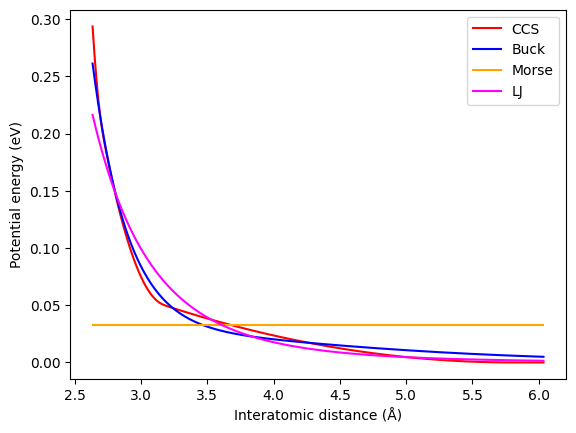

Buckingham fit (not optimised) for element pair Li-Ni;     V(r) = 30.11*exp(-1.12*r) -(249.18)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Ni;  V(r) = 4*-0.85*((2.52/r)^12 - (2.52/r)^6)
Morse fit (not optimised) for element pair Li-Ni;          V(r) = 1.11*(1-np.exp(-7.93*(r-0.00)))^2 + -0.83


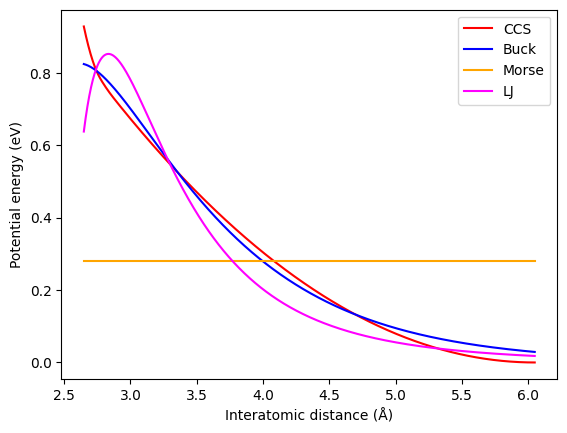

Buckingham fit (not optimised) for element pair Li-O;     V(r) = -39.44*exp(-1.67*r) -(-24.16)/r^6.
Lennard Jones fit (not optimised) for element pair Li-O;  V(r) = 4*1.10*((1.75/r)^12 - (1.75/r)^6)
Morse fit (not optimised) for element pair Li-O;          V(r) = 1.80*(1-np.exp(-1.56*(r-1.32)))^2 + -1.78


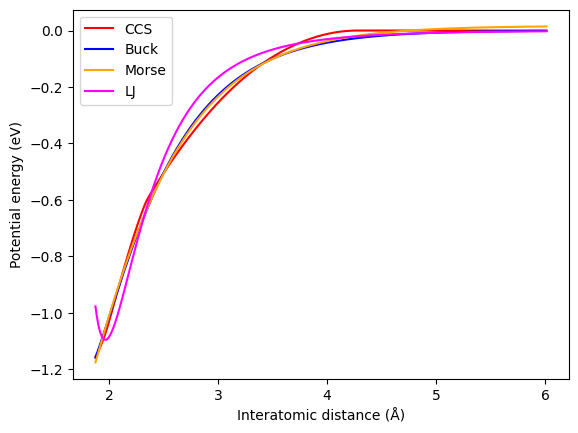

C:\Users\Fremo211\Anaconda3\envs\Tantalizing\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Buckingham fit (not optimised) for element pair Ni-Ni;     V(r) = 8.49*exp(-23.08*r) -(-10363.48)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Ni;  V(r) = 4*-1675257.42*((0.34/r)^12 - (0.34/r)^6)
Morse fit (not optimised) for element pair Ni-Ni;          V(r) = 1.85*(1-np.exp(-10.22*(r-0.01)))^2 + 1.56


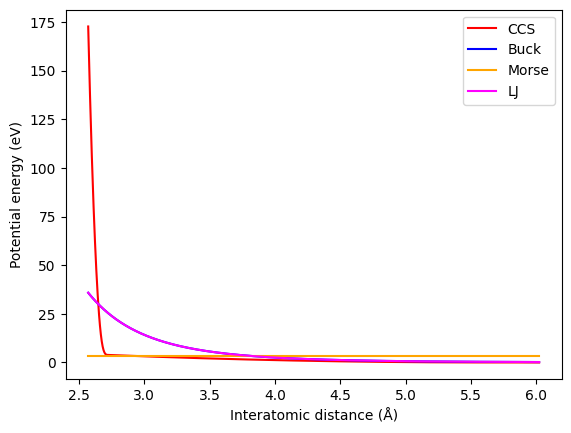

Buckingham fit (not optimised) for element pair Ni-O;     V(r) = -111.60*exp(-1.18*r) -(-140.13)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-O;  V(r) = 4*11.71*((1.67/r)^12 - (1.67/r)^6)
Morse fit (not optimised) for element pair Ni-O;          V(r) = 10.39*(1-np.exp(-1.19*(r-1.47)))^2 + -10.40


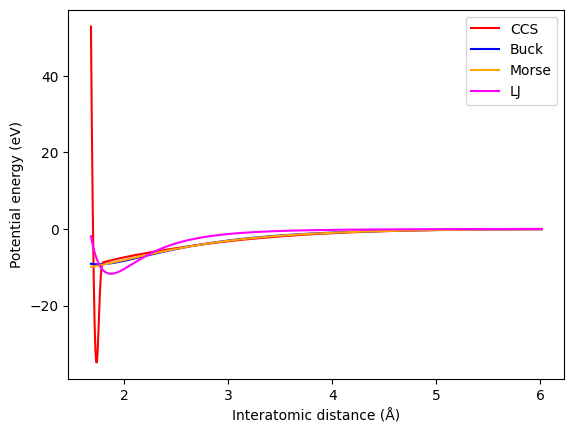

Buckingham fit (not optimised) for element pair O-O;     V(r) = 0.59*exp(-0.21*r) -(-983.05)/r^6.
Lennard Jones fit (not optimised) for element pair O-O;  V(r) = 4*-353471.36*((0.30/r)^12 - (0.30/r)^6)
Morse fit (not optimised) for element pair O-O;          V(r) = 0.30*(1-np.exp(-11.26*(r-0.00)))^2 + 0.95


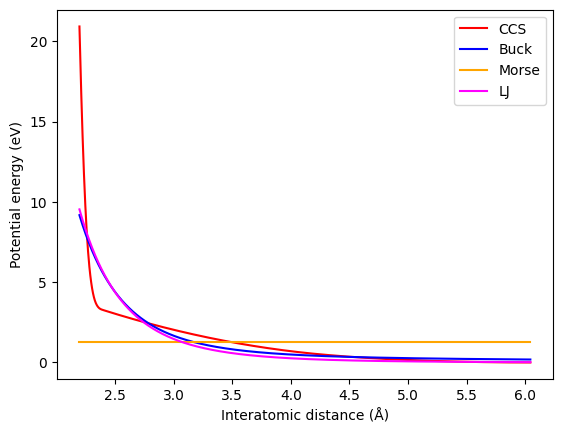

In [9]:
write_FF("CCS_params.json")